In [44]:


%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn

from abstractModule import AbstractLinear as AL
from abstractModule import AbstractReLU as AR

from util.train import Train as T
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
from torch import optim
import os




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:

path ='dataset'

os.makedirs(path, exist_ok=True)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.2]),
        #transforms.Resize((56,56))
    ])



dataset_train = datasets.FashionMNIST(root = path,transform = transform, download = True, train = True)
dataset_test =datasets.FashionMNIST( root =path,transform=transform ,download = True, train = False)
val =0.2
len_data_train = len(dataset_train)
train_size =int((1-val)*len_data_train)

val_size = int(val*len_data_train)

train_dataset, val_dataset = random_split(dataset_train, [train_size,val_size])


In [35]:
class SimpleNN(nn.Module):
    def __init__(self,num_classes=10, num_depth=1):

        super(SimpleNN, self).__init__()
        self.num_classes=num_classes
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=num_depth, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
          
        )
           
   
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=18432, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(in_features=64, out_features=self.num_classes),
        )
        self.softMax =nn.Softmax()
    def forward(self, x):
        x = self.conv_block1(x)
 
        x = self.classifier(x)
        x = self.softMax(x)

        return x


In [46]:


class AbstractNN(nn.Module):
    
    def __init__(self,num_depth=1,device=torch.device("cpu")):

        super(AbstractNN,self).__init__()
       
      
        self.num_depth = num_depth
        self.device = device
        self.conv1=nn.Conv2d(self.num_depth,16,3,device=self.device)
        self.conv2=nn.Conv2d(16,32,3,device=self.device)
       

        self.fc1=nn.Sequential(nn.Flatten(),nn.Linear(18432,64,device=self.device))
        self.fc2=nn.Sequential(nn.Flatten(),nn.Linear(64,10,device=self.device))
        self.softMax =nn.Softmax()
    def forward(self,x):
        x=self.conv1(x)
        x=torch.relu(x)
        x=self.conv2(x)
        x=torch.relu(x)
        x=self.fc1(x)
        x=torch.relu(x)
        x=self.fc2(x)
        x=torch.relu(x)
        x= self.softMax(x)
        return x
    
    def abstract_forward(self,x,add_symbol=False,device=torch.device("cpu")):
        self.device=device
        
        x_true = x
        x_true = x_true[0].unsqueeze(0)
        print(f"lenx:{len(x)}")
        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv1,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
       
        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv2,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
        
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc1,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc2,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
        print(f"lenx:{len(x)}")
        
        return x,x_min,x_max,x_true
        

In [47]:
model =AbstractNN()
num_epochs =10
learning_rate=0.01
batch_size = 128
device = torch.device("cpu")
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.99))
scheduler =  optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.98)
criterion = nn.CrossEntropyLoss()
TD= T(model=model,
            device=device
                            )
model = TD.train_model(train_dataset,val_dataset,
                        criterion=criterion,  
                        batch_size= batch_size,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        num_epochs=num_epochs,
                        learning_rate=learning_rate,
                        resname='SimpleCNN')

----------------------------------------------------------------------------------------------------
Epoch 0/10
----------------------------------------------------------------------------------------------------
batch_loss 1_Epoch_0=2.30, accuracy = 7.03%


/home/guillaume/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


batch_loss 100_Epoch_0=1.80, accuracy = 65.62%
batch_loss 200_Epoch_0=1.76, accuracy = 69.53%
batch_loss 300_Epoch_0=1.71, accuracy = 74.22%
EPOCH ACCURACY = 54.10 %
****************************************************************************************************
train Loss: 1.6515 Acc: 54.1016
****************************************************************************************************
batch_loss 1_Epoch_0=1.64, accuracy = 82.03%
batch_loss 2_Epoch_0=1.66, accuracy = 79.69%
batch_loss 3_Epoch_0=1.62, accuracy = 84.38%
batch_loss 4_Epoch_0=1.74, accuracy = 71.09%
batch_loss 5_Epoch_0=1.72, accuracy = 75.00%
batch_loss 6_Epoch_0=1.73, accuracy = 74.22%
batch_loss 7_Epoch_0=1.68, accuracy = 78.91%
batch_loss 8_Epoch_0=1.66, accuracy = 80.47%
batch_loss 9_Epoch_0=1.65, accuracy = 81.25%
batch_loss 10_Epoch_0=1.71, accuracy = 75.78%
batch_loss 11_Epoch_0=1.70, accuracy = 76.56%
batch_loss 12_Epoch_0=1.70, accuracy = 77.34%
batch_loss 13_Epoch_0=1.68, accuracy = 78.12%
batch_loss 

In [4]:
model = AbstractNN()

In [5]:
model

AbstractNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=18432, out_features=64, bias=True)
  )
  (fc2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [6]:
model = SimpleModel()

In [7]:
model

SimpleModel(
  (conv_block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=18432, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
  (softMax): Softmax(dim=None)
)

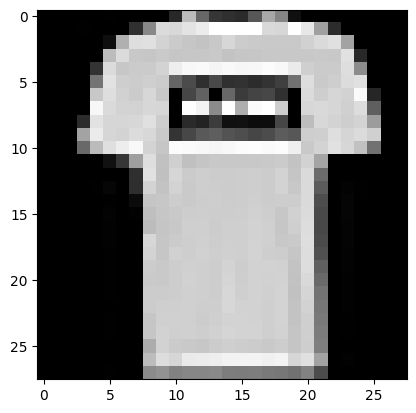

In [157]:
import matplotlib.pyplot as plt
img, label = dataset_train[1]
plt.imshow(img[0], cmap='gray')

In [158]:
max= torch.max(img)
min = torch.min(img)
scale = max-min
from abstract import abstractTensor as AT

x=AT(img.squeeze(0),alpha =0.001*scale*torch.ones(28*28))
x=x.abstract_tensor()
x.shape

torch.Size([28, 28])


torch.Size([786, 28, 28])

In [166]:
with torch.no_grad():
 
   result,x_min,x_max,x_true=model.abstract_forward(x.unsqueeze(1),add_symbol=False)


print(f"y_min       =  {x_min}")
print(f"y_max       =  {x_max}")
print(f"center Ztp  =  {result[0]}")
print(f"y_true      =  {x_true[:]}")
print(f"y_max-x_min =  {x_max-x_min}")
print(f"Trash symbol=  {result[-1]}")


lenx:786
x.shape=torch.Size([786, 1, 28, 28])
lenx:786
x.shape=torch.Size([786, 16, 26, 26])
lenx:786
torch.FloatTensor
lenx:786
torch.FloatTensor
lenx:786
y_min       =  tensor([36.8440,  0.0859,  7.1720, -0.0000, -0.0000, -0.0000,  7.5760, -0.0000,
        -0.0000, -0.0000])
y_max       =  tensor([38.7622,  1.7100,  9.2058,  0.0000,  0.0000,  0.0000,  9.4372,  0.0000,
         0.0000,  0.0000])
center Ztp  =  tensor([37.8031,  0.8980,  8.1889, -0.0000, -0.0000, -0.0000,  8.5066, -0.0000,
        -0.0000, -0.0000])
y_true      =  tensor([[37.8073,  0.9050,  8.2148,  0.0000,  0.0000,  0.0000,  8.5005,  0.0000,
          0.0000,  0.0000]])
y_max-x_min =  tensor([1.9182, 1.6241, 2.0339, 0.0000, 0.0000, 0.0000, 1.8613, 0.0000, 0.0000,
        0.0000])
Trash symbol=  tensor([0.4463, 0.5058, 0.4977, 0.0000, 0.0000, 0.0000, 0.4380, 0.0000, 0.0000,
        0.0000])


Voici le premier affichage de relevance calculé par AbstractTorch

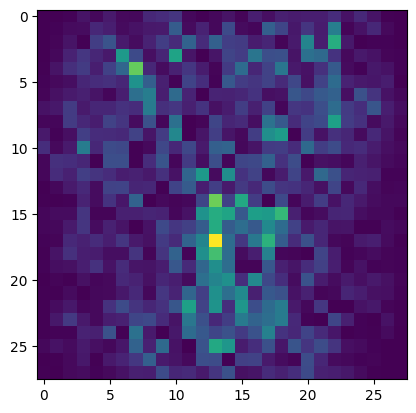

In [167]:
result = result[1:785,1]
result = result.reshape(28,28)
plt.imshow(torch.abs(result.cpu()).numpy(), cmap='viridis')